# Code for the extended exercise

The code for all of the tasks are included and labeled in this document.

## 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### a.

In [2]:
class KnockInOption:
    def __init__(self, S_0, K, T, r, delta, sigma, H, n):
        self.S_0 = S_0
        self.K = K
        self.T = T
        self.r = r
        self.delta = delta
        self.sigma = sigma
        self.H = H
        self.n = n # Timesteps
        self.h = self.T/self.n # Binomial timestep length
        self.u = np.exp((r - delta) * self.h + sigma * np.sqrt(self.h))
        self.d = np.exp((r - delta) * self.h - sigma * np.sqrt(self.h))
        self.p_star = (np.exp((r - delta) * self.h) - self.d) / (self.u - self.d) # Risk-neutral probability

    def prob_barrier_hit(self, t, S):
        return np.exp(-2 / (t * self.sigma**2) * np.abs(np.log(S/self.H) * np.log(self.S_0/self.H)))

    def S_prices(self):
        # Gives price of S^i_t (at time t = h*k, k = 0, 1, ..., n and number of up movements i = 0, 1, ..., k)
        S_list = [] # Two-dimensional list containing, for each t, a list of all possible S^i 
        for k in range(self.n + 1): # For each time step
            S_t = np.zeros(k + 1) # Numpy-array of S^i_t when time is t = h*k
            for i in range(k + 1): # For each number of up movements
                S_t[i] = self.S_0 * self.u**i * self.d**(k - i)
            S_list.append(S_t)
        return S_list
    
    def option_terminal_payoff(self, S_T):
        payoff_knocked_in = np.maximum(S_T - self.K, 0) # Payoff if barrier is hit
        if S_T >= self.H:
            return payoff_knocked_in
        else:
            # Weigh the payoff by the probability of the barrier being hit
            p_barrier_hit = self.prob_barrier_hit(self.T, S_T)
            expected_payoff = p_barrier_hit * payoff_knocked_in
            return expected_payoff
        
    def option_price_binom(self):
        S_prices = self.S_prices()
        S_T = S_prices[-1] # Prices at time T
        O_T = np.vectorize(self.option_terminal_payoff)(S_T) # Terminal option prices. Vectorize for elementwise application
        O_t = O_T # oPtion prices at time t
        for k in range(self.n - 1, -1, -1): # Go one step backward in the tree 
            O_t = (O_t[1:] * self.p_star + O_t[:-1] * (1 - self.p_star)) * np.exp(-self.r * self.h) # Option price at t-1 using risk-neutral pricing
        return O_t[0] # Price at t=0

# Parameters
S_0 = 110
K = 100
T = 5
r = 0.05
delta = 0.02
sigma = 0.3
n = 1000 # Number of timesteps

for H in [190, 110]:
    option = KnockInOption(S_0, K, T, r, delta, sigma, H, n)
    price = option.option_price_binom()
    print(f"Barrier knock-in call with H={H} calculated with a binomial tree, has price {price}")



Barrier knock-in call with H=190 calculated with a binomial tree, has price 31.959667437220087
Barrier knock-in call with H=110 calculated with a binomial tree, has price 35.603961310574384


### b.

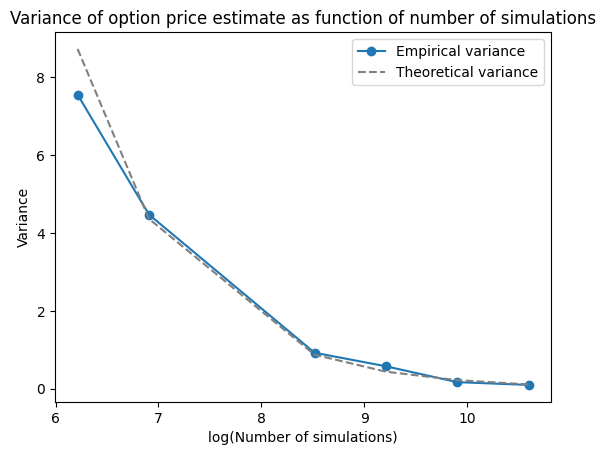

- In the plot we have superimposed the variance formula from slide 28, lecture 7: σ^2_n = σ^2_c / n , where σ^2_c, the variance of a single draw, is estimated to 4365.55
- Estimated option price across 40 runs of 40000 draws each: 31.77818357778663
- Empirical variance with 40000 draws, estimated using 40 simulation runs: 0.09604494638470022.
- Standard deviation: 0.30991119112529675, which is 0.98% of the mean. We deem this sufficient convergence.


In [3]:
np.random.seed(1)

class KnockInOptionMC:
    def __init__(self, S_0, K, T, r, delta, sigma, H, n):
        self.S_0 = S_0
        self.K = K
        self.T = T
        self.r = r
        self.delta = delta
        self.sigma = sigma
        self.H = H
        self.n = n
        self.h = self.T/self.n 

    def montecarlo_barrier_sim(self, num_sims = 10000, return_variance = False):
        S = np.zeros((num_sims, self.n + 1)) # One row for each simulation, one column for each timestep
        S[:, 0] = self.S_0
        for i in range(1, self.n + 1):
            Z = np.random.normal(size = num_sims)
            S[:, i] = S[:, i - 1] * np.exp((self.r - self.delta - 0.5 * self.sigma**2) * (self.h) +
                            self.sigma * np.sqrt(self.h) * Z)
        S_T = S[:, -1]
        max_prices = np.max(S, axis = 1)
        barrier_hit = max_prices >= self.H
        S_T[barrier_hit == False] = 0 # Nullify stock prices where barrier was not hit
        payoff = np.maximum(S_T - self.K, 0)
        option_price = np.mean(payoff) * np.exp(-self.r * self.T) # Discounted expected payoff
        if return_variance:
            return option_price, np.var(payoff) * np.exp(-2 * self.r * self.T)
        return option_price
    
    def variance_of_one_draw(self, num_sims = 10000): # Returns variance of option price estimate
        _, var = self.montecarlo_barrier_sim(num_sims, return_variance = True)
        return var

    def mean_and_variance_of_simulation(self, num_sims, num_trials):
        prices = np.zeros(num_trials)
        for i in range(num_trials):
            prices[i] = self.montecarlo_barrier_sim(num_sims)
        return np.mean(prices), np.var(prices)
    
    def plot_variance(self, num_sims_list, num_trials):
        means, variances = np.vectorize(self.mean_and_variance_of_simulation)(num_sims_list, num_trials)
        plt.plot(np.log(num_sims_list), variances, label = "Empirical variance", marker = "o")
        plt.xlabel("log(Number of simulations)")
        plt.ylabel("Variance")
        plt.title(f"Variance of option price estimate as function of number of simulations")
        # Plot theoretical variance: inversely proportional to number of simulations in a run
        var_one_draw = self.variance_of_one_draw()
        plt.plot(np.log(num_sims_list), var_one_draw / num_sims_list, label = "Theoretical variance", linestyle = "--", color = "gray")
        plt.legend()
        plt.show()
        print(f"- In the plot we have superimposed the variance formula from slide 28, lecture 7: σ^2_n = σ^2_c / n , where σ^2_c, the variance of a single draw, is estimated to {round(var_one_draw,2)}")
        print(f"- Estimated option price across {num_trials} runs of {num_sims_list[-1]} draws each: {means[-1]}")
        print(f"- Empirical variance with {num_sims_list[-1]} draws, estimated using {num_trials} simulation runs: {variances[-1]}.")
        print(f"- Standard deviation: {np.sqrt(variances[-1])}, which is {np.sqrt(variances[-1]) / means[-1] * 100:.2f}% of the mean. We deem this sufficient convergence.")
    
H = 190
montecarlo_option = KnockInOptionMC(S_0, K, T, r, delta, sigma, H, n)
num_sims_list = [500, 1000, 5000, 10000, 20000, 40000]
num_trials = 40
montecarlo_option.plot_variance(num_sims_list, num_trials)


### c.

In [4]:
H = 190
sigmas = [0.2, 0.3, 0.4]

for sigma in sigmas:
    montecarlo_option = KnockInOptionMC(S_0, K, T, r, delta, sigma, H, n)
    price = montecarlo_option.montecarlo_barrier_sim(num_sims=40000)
    print(f"MC-estimated price of an European knock-in option at σ = {sigma*100}%: {price}")


MC-estimated price of an European knock-in option at σ = 20.0%: 19.86008796757295
MC-estimated price of an European knock-in option at σ = 30.0%: 31.571315732288454
MC-estimated price of an European knock-in option at σ = 40.0%: 40.73527283669878


### d.


In [5]:
S_0 = 110
K = 100
T = 5
r = 0.05
delta_no_div = 0.0
sigma = 0.3
n = 1000 
H = 160

montecarlo_option_H160 = KnockInOptionMC(S_0, K, T, r, delta_no_div, sigma, H, n)
price_H160 = montecarlo_option_H160.montecarlo_barrier_sim(num_sims=40000)
print(f"MC-estimated price of an american knock-in option with barrier at 160: {price_H160}")


MC-estimated price of an american knock-in option with barrier at 160: 42.326531694863974


## 2

### a.

In [ ]:
def binomial_tree_discrete_dividends(
    S: float,
    K: float,
    T: float,
    r: float,
    sigma: float,
    q: float,
    div_times: list[float],
    div_amounts: list[float],
    option_type: str,
    style: str,
    n: int,
):
    """
    Calculates the price of an option (European or American, call or put)
    using a binomial tree model, considering discrete dividends.

    Args:
        S (float): Current stock price.
        K (float): Strike price.
        T (float): Time to maturity (in years).
        r (float): Risk-free interest rate (continuously compounded).
        sigma (float): Volatility of the stock.
        q (float): Continuous dividend yield.  This is used for the *prepaid forward* volatility adjustment, and only applies *before* the discrete dividends.
        div_times (list): List of times (in years) when dividends are paid.
        div_amounts (list): List of dividend amounts paid at the corresponding div_times.
        option_type (str): 'call' or 'put'.
        style (str): 'european' or 'american'.
        n (int): Number of time steps in the binomial tree.
    """
    # Input validation
    if option_type.lower() not in ("call", "put"):
        raise ValueError("option_type must be 'call' or 'put'")
    if style.lower() not in ("european", "american"):
        raise ValueError("style must be 'european' or 'american'")
    if len(div_times) != len(div_amounts):
        raise ValueError("div_times and div_amounts must have the same length")
    if any(t > T for t in div_times):
        raise ValueError("Dividend times cannot be greater than the time to maturity")
    if n <= 0:
        raise ValueError("Number of steps 'n' must be a positive integer.")

    dt = T / n  # Length of each time step

    # 1. Compute PV of dividends & prepaid forward price
    pv_dividends = sum(div * np.exp(-r * t) for t, div in zip(div_times, div_amounts))
    S_prepaid = S - pv_dividends  # Stock price adjusted for dividends

    # 2. calculate u, d and p
    u = np.exp((r - q) * dt + sigma * np.sqrt(dt))  # Up factor
    d = np.exp((r - q) * dt - sigma * np.sqrt(dt))  # Down factor
    p = (np.exp((r - q) * dt) - d) / (u - d)  # Risk-neutral probability

    if not (0 <= p <= 1):
        raise ValueError(
            "Arbitrage opportunity detected (risk-neutral probability is not between 0 and 1).  Check your parameters."
        )

    # 3. Build stock and option trees
    stock_tree = np.zeros((n + 1, n + 1))  # Initialize stock price tree
    stock_tree[0, 0] = S_prepaid  # Initial stock price

    for div_time, div_amount in zip(div_times, div_amounts):
        if div_time < dt:
            stock_tree[0, 0] += div_amount  # Add dividend if paid at this time
        elif div_time >= dt:
            stock_tree[0, 0] += div_amount * np.exp(-r * div_time)  # Discounted dividend
    
    for i in range(1, n + 1):
        for j in range(i + 1):
            stock_tree[j, i] = S_prepaid * (u ** (i - j)) * (d**j)  # Stock price at node (i, j)
            for div_time, div_amount in zip(div_times, div_amounts):
                if div_time < (i + 1) * dt and div_time >= i * dt:
                    stock_tree[j, i] += div_amount  # Add dividend if paid at this time

                elif div_time >= (i + 1) * dt:
                    stock_tree[j, i] += div_amount * np.exp(-r * (div_time - i * dt)) # Discounted dividend

    option_tree = np.zeros((n + 1, n + 1))  # Initialize option price tree
    for j in range(n + 1):
        if option_type.lower() == "call":
            option_tree[j, n] = max(0, stock_tree[j, n] - K)  # Call option payoff at expiration
        else:  # put
            option_tree[j, n] = max(0, K - stock_tree[j, n])  # Put option payoff at expiration

    # 4. Work backwards through the tree
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            european_value = np.exp(-r * dt) * (
                p * option_tree[j, i + 1] + (1 - p) * option_tree[j + 1, i + 1]
            )  # Expected option value

            if (
                style.lower() == "american"
            ):  # 5. The price is calculated differently for American options
                if option_type.lower() == "call":
                    intrinsic_value = max(0, stock_tree[j, i] - K)  # Call option intrinsic value
                else:
                    intrinsic_value = max(0, K - stock_tree[j, i])  # Put option intrinsic value
                option_tree[j, i] = max(european_value, intrinsic_value)  # Option value is max of intrinsic and expected
            else:
                option_tree[j, i] = european_value  # European option value

    return option_tree[0, 0], stock_tree, option_tree  # Return option price

In [7]:
S = 41  # Current stock price
K = 40  # Strike price
T = 1    # Time to maturity (1 year)
r = 0.08 # Risk-free interest rate
sigma = 0.3392 # Volatility
q = 0    # Continuous dividend yield
div_times = [2/3]  # Dividend times (in years)
div_amounts = [5]  # Dividend amounts
option_type = 'call'      # Option type
style = 'american'   # Option style
n = 3     # Number of steps


option_price, _, _ = binomial_tree_discrete_dividends(S, K, T, r, sigma, q, div_times, div_amounts, option_type, style, n)
print(f"American Call Option Price (McDonald Replication, n={n}): {option_price:.3f}")
if np.abs(option_price - 5.770) < 0.001: # 5.770 is the expected result from McDonald (2013)
    print("The result is correct")
else:
    print("The result is incorrect")

American Call Option Price (McDonald Replication, n=3): 5.770
The result is correct


In [8]:
S = 41
K = 40
T = 0.25
r = 0.08
div_times = [1/12]
div_amounts = [3]
sigma = 0.3
option_type = 'call'
style = 'european'
q = 0
n = 900
option_price, _, _ = binomial_tree_discrete_dividends(S, K, T, r, sigma, q, div_times, div_amounts, option_type, style, n)
print(f"European Call Option Price (McDonald Replication, n={n}): {option_price:.3f}")
if np.abs(option_price - 1.763) < 0.001: # 1.763 is the expected result from McDonald (2013)
    print("The result is correct")
else:
    print("The result is incorrect")

European Call Option Price (McDonald Replication, n=900): 1.763
The result is correct


### b.

Option price with 5 steps: 4.4079
Option price with 50 steps: 4.2391
Option price with 100 steps: 4.2235


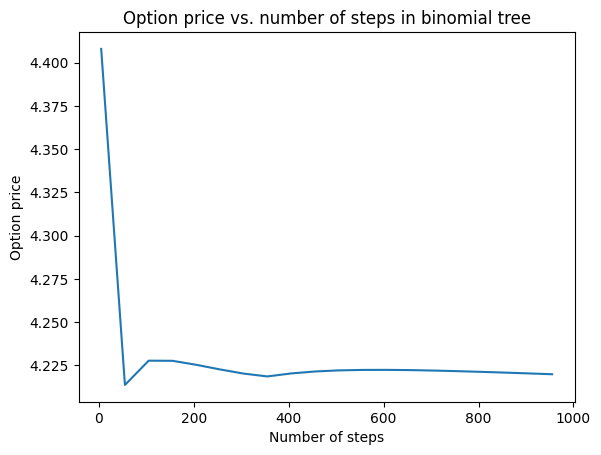

In [9]:
S = 52  # Initial stock price
K = 50  # Strike price
T = 5 / 12  # Time to maturity (5 months)
r = 0.10  # Risk-free interest rate (10% per annum)
sigma = 0.40  # Volatility (40% per annum)
div_times = [3.5 / 12]  # Dividend time (3.5 months)
div_amounts = [2.06]  # Dividend amount
option_type = 'put'  
style = 'american'  
q = 0 # no continuous dividend yield

n_values = [5, 50, 100]
option_prices = []

for n in n_values:
    price, _, _ = binomial_tree_discrete_dividends(S, K, T, r, sigma, q, div_times, div_amounts, option_type, style, n)
    option_prices.append(price)
    print(f"Option price with {n} steps: {price:.4f}")


import matplotlib.pyplot as plt

n_values = range(5, 1000, 50)
option_prices = []

for n in n_values:
    price, _, _ = binomial_tree_discrete_dividends(S, K, T, r, sigma, q, div_times, div_amounts, option_type, style, n)
    option_prices.append(price)
    
plt.plot(n_values, option_prices)
plt.xlabel("Number of steps")
plt.ylabel("Option price")
plt.title("Option price vs. number of steps in binomial tree")
plt.show()


In [ ]:
def generate_latex_tree_mcdonald(stock_tree: list[list[float]], option_tree: list[list[float]], n: int):
    """
    Utility function that generates LaTeX code for a binomial tree.
    """

    latex_code = r"""
\begin{tikzpicture}[
    x=1.5cm,  % Horizontal spacing
    y=1.2cm,  % Vertical spacing (positive for upwards growth)
    font=\footnotesize,
    every node/.style={align=center} % Center-align text
]

"""

    for i in range(n + 1):
        for j in range(i + 1):
            node_content = (
                f"${stock_tree[j, i]:.3f}$\\\\"
                f"${option_tree[j, i]:.3f}$"
            )
            y_coord =  (i / 2.0) - j
            latex_code += f"\\node at ({i},{y_coord}) (node{i}{j}) {{{node_content}}};\n"

    for i in range(n + 1):
        for j in range(i + 1):
            if i < n:
                latex_code += f"\\draw (node{i}{j}) -- (node{i+1}{j});\n"
                latex_code += f"\\draw (node{i}{j}) -- (node{i+1}{j+1});\n"

    latex_code += r"""
\end{tikzpicture}
\caption{Binomial tree for the case with 5 time steps}
"""
    return latex_code

price, stock_tree, option_tree = binomial_tree_discrete_dividends(S, K, T, r, sigma, q, div_times, div_amounts, option_type, style, 5)
latex_output = generate_latex_tree_mcdonald(stock_tree, option_tree, 5)
print(latex_output)


\begin{tikzpicture}[
    x=1.5cm,  % Horizontal spacing
    y=1.2cm,  % Vertical spacing (positive for upwards growth)
    font=\footnotesize,
    every node/.style={align=center} % Center-align text
]

\node at (0,0.0) (node00) {$52.000$\\$4.408$};
\node at (1,0.5) (node10) {$58.606$\\$2.013$};
\node at (1,-0.5) (node11) {$46.937$\\$6.612$};
\node at (2,1.0) (node20) {$66.081$\\$0.513$};
\node at (2,0.0) (node21) {$52.874$\\$3.381$};
\node at (2,-1.0) (node22) {$42.390$\\$9.595$};
\node at (3,1.5) (node30) {$74.548$\\$0.000$};
\node at (3,0.5) (node31) {$59.600$\\$0.979$};
\node at (3,-0.5) (node32) {$47.734$\\$5.574$};
\node at (3,-1.5) (node33) {$38.316$\\$13.329$};
\node at (4,2.0) (node40) {$82.041$\\$0.000$};
\node at (4,1.0) (node41) {$65.123$\\$0.000$};
\node at (4,0.0) (node42) {$51.694$\\$1.866$};
\node at (4,-1.0) (node43) {$41.034$\\$8.966$};
\node at (4,-2.0) (node44) {$32.572$\\$17.428$};
\node at (5,2.5) (node50) {$92.854$\\$0.000$};
\node at (5,1.5) (node51) {$73.706$\

## 3

In [11]:
tons = 200000  # Annual LNG quantity
forward_prices = [400, 420, 450]  # Forward prices per ton for Years 1, 2, 3
rates = [0.015, 0.02, 0.025]  # Effective annual interest rates for 1, 2, 3 years

### b.

In [12]:
# PV of forward prices
pv_forward = sum(f / (1 + r) ** (i + 1) for i, (f, r) in enumerate(zip(forward_prices, rates)))

# Sum of discount factors for fixed payments
discount_sum = sum(1 / (1 + r) ** (i + 1) for i, r in enumerate(rates))
print(discount_sum)

# Fixed swap price per ton
S = pv_forward / discount_sum
total_annual_payment = S * tons

print(f"Part b) Fixed swap price per ton: ${S:.2f}")
print(f"Total annual payment for {tons} tons: ${total_annual_payment:,.2f}")



2.8749898670345817
Part b) Fixed swap price per ton: $422.84
Total annual payment for 200000 tons: $84,567,205.40


### c.

In [13]:
# Cash flows to GasExpo: Ft - S each year, discounted back to time 0
npv_gasexpo = sum((f - S) / (1 + r) ** (i + 1) for i, (f, r) in enumerate(zip(forward_prices, rates)))
npv_counterparty = -npv_gasexpo  # Counterparty's NPV is opposite

print(f"Part c) NPV of GasExpo's cash flows: ${npv_gasexpo:.4f}")
print(f"NPV of Counterparty's cash flows: ${npv_counterparty:.4f}")

Part c) NPV of GasExpo's cash flows: $-0.0000
NPV of Counterparty's cash flows: $0.0000


### d.

In [14]:
overpayments = [(S - f) for f in forward_prices[:2]]  # Years 1 and 2
pv_overpayments = [op / (1 + rates[i]) ** (i + 1) for i, op in enumerate(overpayments)]
cumulative_pv_overpayment_per_ton = sum(pv_overpayments)
total_overpayment = cumulative_pv_overpayment_per_ton * tons

print(f"Part d) Cumulative PV of overpayment per ton after Year 2: ${cumulative_pv_overpayment_per_ton:.4f}")
print(f"Total cumulative overpayment for {tons} tons: ${total_overpayment:,.2f}")

Part d) Cumulative PV of overpayment per ton after Year 2: $25.2244
Total cumulative overpayment for 200000 tons: $5,044,889.87
